# Corridor generation

In this notebook, the location of the corridors is being generated based on the voxel seeds. This for the corridors on the groundfloor, that connect al communal functions and all housing entrances. The public functions have their own entrance on street level.
For each function seed and the entrance location a shaft location is generated, and a connection is found to two of their closest shafts to generate a corridornetwork for this floor. 

## 0. Initialization

### 0.1. Load required libraries

In [17]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import numpy as np
import networkx as nx
import pandas as pd
import scipy as sp
import pickle
from sklearn.cluster import KMeans
np.random.seed(0)
import copy

In [18]:
# extra import function
def lattice_from_csv(file_path):
    # read metadata
    meta_df = pd.read_csv(file_path, nrows=3)

    shape = np.array(meta_df['shape'])
    unit = np.array(meta_df['unit'])
    minbound = np.array(meta_df['minbound'])

    # read lattice
    lattice_df = pd.read_csv(file_path, skiprows=5)

    # create the buffer
    buffer = np.array(lattice_df['value']).reshape(shape)

    # create the lattice
    l = tg.to_lattice(buffer, minbound=minbound, unit=unit)

    return l

### 0.2. Define the Neighborhood (Stencil)

In [19]:
# creating neighborhood definition
s_1 = tg.create_stencil("von_neumann", 1, 1)

# setting the center to zero
s_1.set_index([0,0,0], 0)

# creating neighborhood definition
s_2 = tg.create_stencil("von_neumann", 1, 2)
# setting the center to zero
s_2.set_index([0, 0, 0], 0)
s_2.set_index([0, 0, 1], 0)
s_2.set_index([0, 0, 2], 1)
s_2.set_index([0, 0,-1], 0)
s_2.set_index([0, 0,-2], 1)

# setting the center to zero
s_2.set_index([0,0,0], 0)

# creating neighborhood definition
s_3 = tg.create_stencil("von_neumann", 1, 3)
# setting the center to zero
s_3.set_index([0, 0, 0], 0)
s_3.set_index([0, 0, 1], 0)
s_3.set_index([0, 0, 3], 1)
s_3.set_index([0, 0,-1], 0)
s_3.set_index([0, 0,-3], 1)

# setting the center to zero
s_3.set_index([0,0,0], 0)

# creating neighborhood definition
s_groundfloor = tg.create_stencil("von_neumann", 1, 1)

# setting the center to zero
s_groundfloor.set_index([0, 0, 0], 0)
s_groundfloor.set_index([0, 0, 1], 0)
s_groundfloor.set_index([0, 0,-1], 0)

stencils = [s_1, s_2, s_3, s_groundfloor]

h_stencil = s_groundfloor


### 0.3. Load the envelope lattice as the avialibility lattice

In [20]:
# loading the lattice from csv
lattice_path = os.path.relpath('../data/highres_envelope.csv')
avail_lattice = lattice_from_csv(lattice_path)

# loading the lattice from csv
lattice_path = os.path.relpath('../data/avail_lattice_good_voxels.csv')
avail_lattice_good_voxels = lattice_from_csv(lattice_path)
init_avail_lattice = tg.to_lattice(np.copy(avail_lattice_good_voxels), avail_lattice_good_voxels)

avail_lattice*= avail_lattice_good_voxels

### 0.4. Load Agents Information

In [112]:
# loading program (agents information) from CSV
prgm_path = os.path.relpath('../data/program_exported.csv')
agn_info = pd.read_csv('../data/program_exported.csv',delimiter=";")
agn_ids = agn_info["space_id"].values
agn_prefs = agn_info
a_pref = agn_prefs.loc[0]

In [111]:
# Loading program information between agents from CSV
matrix_path = os.path.relpath('../data/program_exported_matrix.csv')
matrix_info = pd.read_csv('../data/program_exported_matrix.csv',delimiter=";")
matrix_ids = matrix_info["space_id"].values
matrix_prefs = matrix_info

### 0.5. Initialize environment information layers from Sun Access Lattice and Entrance Access Lattice

In [23]:
# loading the lattice from csv
sun_acc_path = os.path.relpath('../data/sun_access_highres.csv')
sun_acc_lattice = lattice_from_csv(sun_acc_path)

ent_acc_highres_public_path = os.path.relpath('../data/ent_access_highres_public.csv')
ent_acc_public_lattice = lattice_from_csv(ent_acc_highres_public_path)

ent_acc_highres_housing_path = os.path.relpath('../data/ent_access_highres_housing.csv')
ent_acc_housing_lattice = lattice_from_csv(ent_acc_highres_housing_path)

ent_acc_highres_gym_path = os.path.relpath('../data/ent_access_highres_gym.csv')
ent_acc_gym_lattice = lattice_from_csv(ent_acc_highres_gym_path)

ent_acc_highres_parking_path = os.path.relpath('../data/ent_access_highres_parking.csv')
ent_acc_parking_lattice = lattice_from_csv(ent_acc_highres_parking_path)

ent_acc_highres_comcen_path = os.path.relpath('../data/ent_access_highres_comcen.csv')
ent_acc_comcen_lattice = lattice_from_csv(ent_acc_highres_comcen_path)

highres_sky_acc_path = os.path.relpath('../data/sky_access_highres.csv')
sky_acc_lattice = lattice_from_csv(highres_sky_acc_path)

highres_quietness_acc_path = os.path.relpath('../data/quietness_highres.csv')
quietness_acc_lattice = lattice_from_csv(highres_quietness_acc_path)

groundfloor_acc_path = os.path.relpath('../data/ent_access_highres_groundfloor.csv')
groundfloor_acc_lattice = lattice_from_csv(groundfloor_acc_path)

# list the environment information layers (lattices)
env_info = {"sun_acc": sun_acc_lattice + 0.001,
            "ent_acc_public": ent_acc_public_lattice + 0.001, 
            "ent_acc_housing": ent_acc_housing_lattice + 0.001, 
            "ent_acc_gym": ent_acc_gym_lattice + 0.001,
            "ent_acc_parking": ent_acc_parking_lattice + 0.001, 
            "ent_acc_comcen": ent_acc_comcen_lattice + 0.001,
            "sky_acc": sky_acc_lattice + 0.001,
            "quietness_acc": quietness_acc_lattice + 0.001,
            "ground_floor_acc": groundfloor_acc_lattice + 0.001}

# defining other factors in csv
# defining stencil id
stencil_id = stencils
# area to use in simulation
room_area = []

In [24]:
# generate a list of all communal functions
community = []
print(agn_info["ent_acc_comcen"].values)


for i in agn_ids:
    if agn_info["ent_acc_comcen"][i] == 1:
        
        community.append(agn_ids[i])
print(community)

[1 1 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
[0, 1, 2, 3, 4, 5, 9]


### 1.1. initial agent localisation

In [25]:
def check_avail(avail_lattice, ind, a_stencil_id):
    condition = 1
    ind_array = np.array(ind)
    for step in range(a_stencil_id + 1):
        new_ind_array = ind_array + np.array([0,0,step])
        condition *= avail_lattice[tuple(new_ind_array)]
    return condition

In [26]:
def eval_voxel(vox, env_info, a_pref):
    global_vox_value = 1.0
    # for every lattice in the environment informations
    for key, info_lattice in env_info.items():
        # Here we utilise Fuzzy Logics to be able to compare different layers 
        # of environmental information and evaluate the voxel for the agent. 
        # This method is introduced, and generalised in Pirouz Nourian dissertation: 
        # section 5.7.3, pp. 201-208, eq. 57. You can refer to this section for 
        # comprehensive mathematical details.
        vox_val = info_lattice[tuple(vox)]
        agn_vox_val = np.power(vox_val, a_pref[key])
        global_vox_value *= agn_vox_val
    
    return global_vox_value

In [27]:
def mult_occupation(selected_vox_3d_address, a_id, a_height, agn_locs, agn_src_locs, occ_lattice, avail_lattice, departure=False):
    for step in range(a_height):

        new_address = selected_vox_3d_address + np.array([0,0,step])
        if new_address[2] < occ_lattice.shape[2]:
            # make tuple of the address
            selected_vox_3d_id = tuple(new_address)
            # find the location of the newly selected voxel
            selected_vox_loc = np.array(selected_vox_3d_id).flatten()

            if departure==False:
                # add the newly selected voxel location to agent locations
                agn_locs[a_id].append(selected_vox_loc)
                if step ==0:
                    agn_src_locs[a_id].append(selected_vox_loc)
                # set the newly selected voxel as UNavailable (0) in the availability lattice
                avail_lattice[selected_vox_3d_id] = 0
                # set the newly selected voxel as OCCUPIED by current agent 
                # (-1 means not-occupied so a_id)
                occ_lattice[selected_vox_3d_id] = a_id
            else:
                # remove the newly selected voxel location to agent locations
                a_locs_list = [list(loc) for loc in agn_locs[a_id]]
                try:
                    ind = a_locs_list.index(list(selected_vox_loc))
                    agn_locs[a_id].pop(ind)

                    # set the newly selected voxel as UNavailable (0) in the availability lattice
                    avail_lattice[selected_vox_3d_id] = 1
                    # set the newly selected voxel as OCCUPIED by current agent 
                    # (-1 means not-occupied so a_id)
                    occ_lattice[selected_vox_3d_id] =  -1
                except:
                    pass

    return (agn_locs, agn_src_locs, occ_lattice, avail_lattice)


In [28]:
def find_voxels_masked(lattice, stencil, loc):
    vox_locs = np.argwhere(stencil) - stencil.origin + loc
    vox_filter = np.all(vox_locs > 0, axis=1) * np.all(vox_locs < np.array(lattice.shape), axis=1)
    return(vox_locs[vox_filter])

In [39]:
# initialize the occupation lattice
occ_lattice = avail_lattice * 0 - 1

# Finding the index of the available voxels in avail_lattice
avail_flat = avail_lattice.flatten()
avail_index = np.array(np.where(avail_lattice == 1)).T

# count the number of spaces and intiialize an agent for each space
agn_num = len(agn_info)

# adding the origins to the agents locations
agn_locs = [[] for a_id in agn_ids]
agn_src_locs = [[] for a_id in agn_ids]
agn_upper = []

# retrieving the initial location of each agent
for a_id in community:    
    voxel_vals = []
    pot_voxels = []
    # retrieve agent preferences
    a_pref = agn_prefs.loc[a_id]
    a_stencil_id = 0
    stencil = stencils[a_stencil_id]
    # use avail_index voxel Evaluation Loop
    for pot_vox in avail_index:         
        if check_avail(avail_lattice, tuple(pot_vox), a_stencil_id):
            # evaluate each voxel
            vox_value = eval_voxel(pot_vox, env_info, a_pref)
            # add the voxel value to the list of values
            voxel_vals.append(vox_value)
            pot_voxels.append(pot_vox)

    # convert voxel values to numpy array
    voxel_vals = np.array(voxel_vals)
    # convert potential voxels to numpy array
    pot_voxels = np.array(pot_voxels)
    # select the voxel with highest value 
    selected_int = np.argmax(voxel_vals) 
    # find 3D intiger index of selected voxel
    selected_vox_3d_address = tuple(pot_voxels[selected_int].T)
    # find the location of the newly selected voxel
    agn_origins = np.array(selected_vox_3d_address).flatten()
    # Occupy the newly selected voxel in the occupation lattice
    occ_lattice[selected_vox_3d_address] = 5
    
    agn_locs, agn_src_locs, occ_lattice, avail_lattice = mult_occupation(selected_vox_3d_address, 
                                                                       a_id, 
                                                                       a_stencil_id + 1, 
                                                                       agn_locs,
                                                                       agn_src_locs,
                                                                       occ_lattice, 
                                                                       avail_lattice)


In [94]:
# add entrance voxel to the occ_lattice
occ_lattice[(83, 20, 1)] = 9

### 1.2. Visualizing the simulation

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

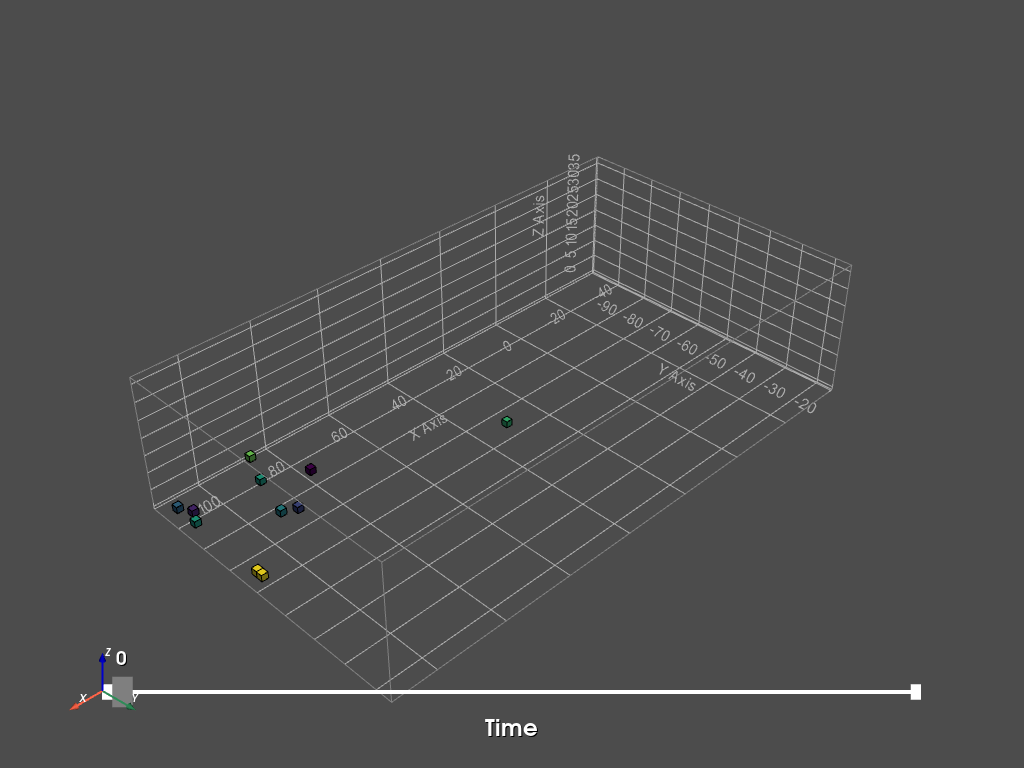

[(235.5051936291799, 141.90519277087301, 217.50519440404028),
 (36.0, -57.600000858306885, 18.000000774860382),
 (0.0, 0.0, 1.0)]

In [95]:
p = pv.Plotter(notebook=True)

base_lattice = occ_lattice

# Set the grid dimensions: shape + 1 because we want to inject our values on the CELL data
grid = pv.UniformGrid()
grid.dimensions = np.array(base_lattice.shape) + 1
# The bottom left corner of the data set
grid.origin = base_lattice.minbound - base_lattice.unit * 0.5
# These are the cell sizes along each axis
grid.spacing = base_lattice.unit 

# adding the boundingbox wireframe
p.add_mesh(grid.outline(), color="grey", label="Domain")

# adding the avilability lattice

# adding axes
p.add_axes()
p.show_bounds(grid="back", location="back", color="#aaaaaa")

agn_num = len(agn_info)

def create_mesh(value):
    f = int(value)
    lattice = base_lattice

    # Add the data values to the cell data
    grid.cell_arrays["Agents"] = lattice.flatten(order="F").astype(int)  # Flatten the array!
    # filtering the voxels
    threshed = grid.threshold([-0.1, 20])
    # adding the voxels
    p.add_mesh(threshed, name='sphere', show_edges=True, opacity=1.0, show_scalar_bar=False)

    return

p.add_slider_widget(create_mesh, [0, 1], title='Time', value=0, event_type="always", style="classic", pointa=(0.1, 0.1), pointb=(0.9, 0.1))
p.show(use_ipyvtk=True)

#saving and plotting
png_path = os.path.relpath('../screenshots/5.1_voxel_seeds_groundfloor.png')
p.show(screenshot= png_path)

save the ground floor latice to csv 
csv_path = os.path.relpath('../data/voxel_seeds.csv')
occ_lattice.to_csv(csv_path)


### 1.3. for each seed, generate a shaft location

In [96]:
occupation_01_lattice = (occ_lattice > -1).astype(int)
# compute the sum over the columns to add weight to locations that might have multiple seeds above eachother
column_sum = np.sum(occupation_01_lattice, axis = 2)

max_value_seeds = np.max(column_sum)
filled_col_list = []

for i in range(1, max_value_seeds + 1): 
    # find adresses of columns
    column_adress = np.where(column_sum == i )
    filled_collumns = np.array(column_adress).T
    filled_col_list.append(filled_collumns)

fill_col_stacked = np.vstack(filled_col_list) 
clusters = len(fill_col_stacked)

In [97]:
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(fill_col_stacked)

In [98]:
col_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

In [99]:
# creating an empty occ lattice
cluster_lattice = occ_lattice * 0 - 1
# iterating over each filled column
for col, lab in zip(fill_col_stacked, col_labels):
    # setting the base of the column into the label value
    cluster_lattice[col[0], col[1], :] = lab

### 1.5. Compute a distance graph


In [100]:
rounded_cluster_centres = np.rint(cluster_centers).astype(int)

shaft_lattice = occ_lattice * 0 
# iterating over each shaft
for i, cen in enumerate(rounded_cluster_centres): 
        shaft_lattice[cen[0], cen[1], :] = i + 1

In [101]:
trimmed_shft_latice = shaft_lattice * init_avail_lattice

In [102]:
# find the number of all voxels
vox_count = avail_lattice.size 

# initialize the adjacency matrix
adj_list = []

# Finding the index of the available voxels in avail_lattice
avail_index = np.array(np.where(avail_lattice == 1)).T

# fill the adjacency matrix using the list of all neighbours
for vox_loc in avail_index:
    # find the 1D id
    vox_id = np.ravel_multi_index(vox_loc, avail_lattice.shape)
    # check whether it is in a shaft or not
    if shaft_lattice[tuple(vox_loc)] > 0:
        # in case that specific voxel is in a shaft
        vox_stencil = stencil
    else: 
        # in case that the voxel is a normal voxel
        vox_stencil = h_stencil
        
    # retrieve the list of neighbours of the voxel based on the stencil
    vox_neighs = avail_lattice.find_neighbours_masked(vox_stencil, loc = vox_loc)
    # iterating over the neighbours
    for neigh in vox_neighs:
        # setting the entry to one
        # adj_mtrx[vox_id, neigh] = 1.0
        adj_list.append([1.0, vox_id, neigh])

In [103]:
import scipy as sp

In [104]:
adj_array = np.array(adj_list)
adj_mtrx_sparse = sp.sparse.csr_matrix((adj_array[:,0],(adj_array[:,1],adj_array[:,2])), shape=(vox_count, vox_count))

In [105]:
g = nx.from_scipy_sparse_matrix(adj_mtrx_sparse)

### 1.6. construct the corridors based on the shortest paths

In [106]:
corridor_lattice = occ_lattice * 0 -1
        
corr_flat = corridor_lattice.flatten()
cor_groundfloor = shaft_lattice[:, :, 1]

shaft_vox_inds = np.array(np.where(cor_groundfloor >0)).T
corr_latt_shape = corridor_lattice.shape        

all_shortest_paths = []
# find the shortest path between all locations to generate a corridor network
for start_shaft in  shaft_vox_inds:
    paths = []
    path_lenghts = []
    for dist_shaft_ind in shaft_vox_inds: 
        # construct the destination adress
        src_vox = np.array([start_shaft[0], start_shaft[1], 2])
        dst_vox = np.array([dist_shaft_ind[0], dist_shaft_ind[1], 2])
        # construct 1-dimentional indices
        src_ind = np.ravel_multi_index(src_vox, corr_latt_shape)
        dst_ind = np.ravel_multi_index(dst_vox, corr_latt_shape)
        # find the shortest path
        try: 
            path = nx.algorithms.shortest_paths.astar.astar_path(g, src_ind, dst_ind)

            if len(path) > 1: 
                paths.append(path)
                path_lenghts.append(len(path))
        except: 
            pass
        
    path_order = np.argsort(np.array(path_lenghts))
    shortest_path = paths[path_order[1]]
    all_shortest_paths.append(paths)
          
corridor_lattice = corr_flat.reshape(corridor_lattice.shape)

In [107]:
# copy the corridors to all voxels that should make use of these corridors (3 voxels heigh for first level, two voxels heigh for second level)
for i, path in enumerate(all_shortest_paths):
    for cen in path: 
        thrd_ind = np.unravel_index(cen, corridor_lattice.shape)
        corridor_lattice[thrd_ind[0], thrd_ind[1], :6] = 1
        corridor_lattice[thrd_ind[0], thrd_ind[1], 0] = -1

In [108]:
p = pv.Plotter(notebook=True)

base_lattice = corridor_lattice

# Set the grid dimensions: shape + 1 because we want to inject our values on the CELL data
grid = pv.UniformGrid()
grid.dimensions = np.array(base_lattice.shape) + 1
# The bottom left corner of the data set
grid.origin = base_lattice.minbound - base_lattice.unit * 0.5
# These are the cell sizes along each axis
grid.spacing = base_lattice.unit 

# adding the boundingbox wireframe

p.add_mesh(grid.outline(), color="grey", label="Domain")

# adding the avilability lattice
# init_avail_lattice.fast_vis(p)

# adding axes
p.add_axes()
p.show_bounds(grid="back", location="back", color="#aaaaaa")




# Add the data values to the cell data
grid.cell_arrays["Agents"] = base_lattice.flatten(order="F").astype(int)  # Flatten the array!
# filtering the voxels
threshed = grid.threshold([-0.1, 20])
# adding the voxels
p.add_mesh(threshed, name='sphere', show_edges=True, opacity=1.0, show_scalar_bar=False)


# p.add_slider_widget(create_mesh, [0, n_frames], title='Time', value=0, event_type="always", style="classic", pointa=(0.1, 0.1), pointb=(0.9, 0.1))
p.show(use_ipyvtk=True)

#saving and plotting
png_path = os.path.relpath('../screenshots/5.2_corridors_groundfloor.png')
p.show(screenshot= png_path)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(235.5051936291799, 141.90519277087301, 217.50519440404028),
 (36.0, -57.600000858306885, 18.000000774860382),
 (0.0, 0.0, 1.0)]

### 2.3. Saving lattice frames in CSV

In [78]:
# save the ground floor latice to csv 
csv_path = os.path.relpath('../data/corridors_groundfloor.csv')
corridor_lattice.to_csv(csv_path)

import pickle
lattice_pickle_path = os.path.relpath('../data/corridors_groundfloor.p')
pickle.dump(corridor_lattice, open(lattice_pickle_path,"wb"))

### Credits

In [33]:
__author__ = "Shervin Azadi and Pirouz Nourian"
__editor__ = "Maartje Damen"
__license__ = "MIT"
__version__ = "1.0"
__url__ = "https://github.com/shervinazadi/spatial_computing_workshops"
__summary__ = "Spatial Computing Design Studio Workshop on MCDA and Path Finding for Generative Spatial Relations"